In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
import tensorflow
print(tensorflow.__version__)
#!pip install "tensorflow-hub>=0.12.0"


2.8.0


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import metrics
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

%matplotlib inline

In [3]:
train_data_dir = r'C:\Users\johns\Desktop\TFG\Dataset\train'
validation_data_dir = r'C:\Users\johns\Desktop\TFG\Dataset\valid'

In [4]:
width_shape = 224
height_shape = 224
epochs = 100
num_classes = len(os.listdir(train_data_dir))
batch_size = 32
image_shape = (224,224,3)

Found 12448 images belonging to 23 classes.
Found 2590 images belonging to 23 classes.


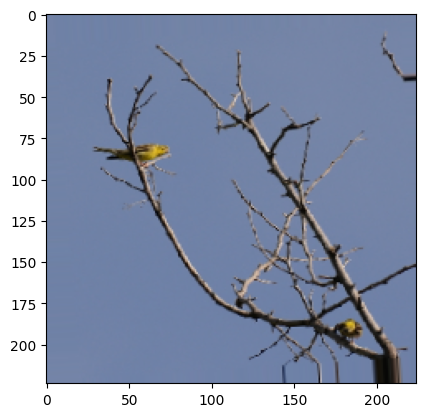

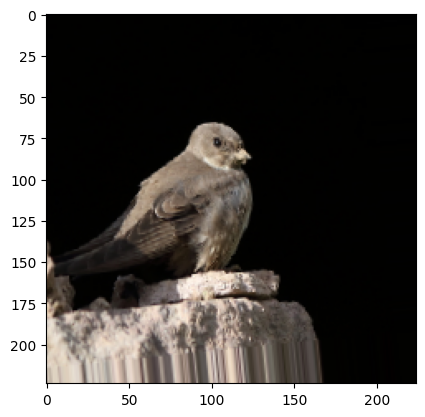

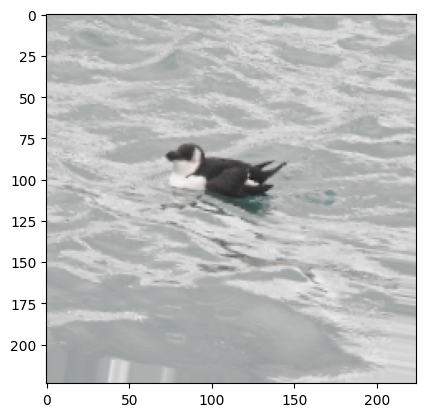

In [5]:
from keras.applications.resnet_v2 import preprocess_input

# Data generators with data augmentation
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(height_shape, width_shape),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = valid_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(height_shape, width_shape),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

for _ in range(3):
    img, label = next(train_generator)
    plt.imshow(img[0])
    plt.show()

In [6]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense, Flatten, Conv2D, MaxPooling2D
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
import tensorflow as tf
import tensorflow_hub as hub
import math

# Cargar el modelo base EfficientNetB0 pre-entrenado con pesos ImageNet
efficient_net = hub.KerasLayer("https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet21k-b3-feature-vector/versions/1",trainable=False)
    
custom_efficientnet_model = keras.Sequential([
    efficient_net,
    keras.layers.Flatten(),  # Add a Flatten layer to reshape the output
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),  
    keras.layers.Dropout(0.5),  
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),  
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(num_classes, activation='softmax'),
])

custom_efficientnet_model.build((None, width_shape, height_shape, 3))

# Compilar el modelo
custom_efficientnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Ajustar la tasa de aprendizaje
                                 loss='categorical_crossentropy',
                                 metrics=['accuracy'])

# Visualizar el resumen del modelo
custom_efficientnet_model.summary()

# Definir callbacks para entrenamiento
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint(r'C:\Users\johns\Desktop\TFG\MasCapas\EfficientNetbest_EfficientNet_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Calcular pesos de clase para el manejo de desbalance de clases
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Crear un diccionario que mapea los índices de clase a sus pesos respectivos
class_weights_dict = dict(zip(np.unique(train_generator.classes), class_weights))

# Calcular pasos por época y pasos de validación
num_train_images = train_generator.samples
num_val_images = validation_generator.samples

steps_per_epoch = math.ceil(num_train_images / batch_size)  # Ajustar el tamaño del lote
validation_steps = math.ceil(num_val_images / batch_size)

# Entrenar el modelo
hist = custom_efficientnet_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=steps_per_epoch,
    class_weight=class_weights_dict,  # Pasar los pesos de clase
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=1
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1536)              12930622  
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

In [8]:
custom_efficientnet_model.save(r"C:\Users\johns\Desktop\TFG\MasCapas\EfficientNet\custom_EfficientNet_model.h5")

In [9]:
def plotTraining(hist, epochs, typeData):

    if typeData=="loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'-r',label='Loss Training')
    if typeData=="accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-r',label='Accuracy Training')
    if typeData=="val_loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['val_loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'-b',label='Loss Validate')
    if typeData=="val_accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['val_accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-b',label='Training Validate')


    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    plt.rc('legend', fontsize=18)
    plt.legend()
    plt.xlabel('Number of Epochs',fontsize=24)
    plt.grid(True)

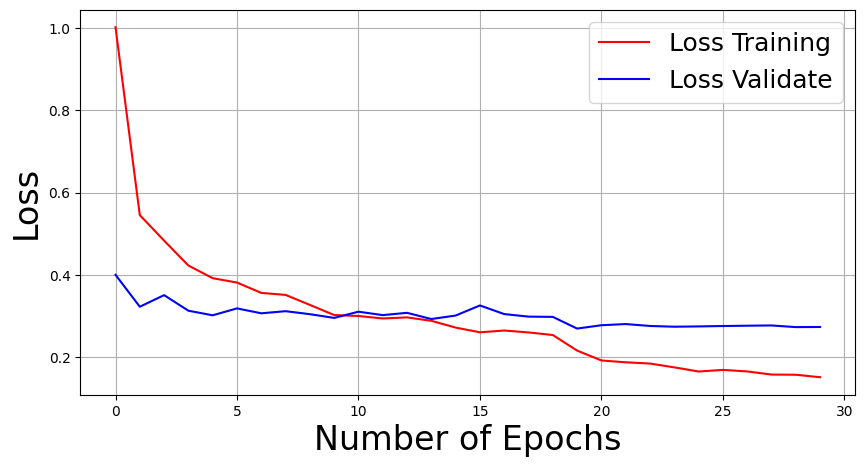

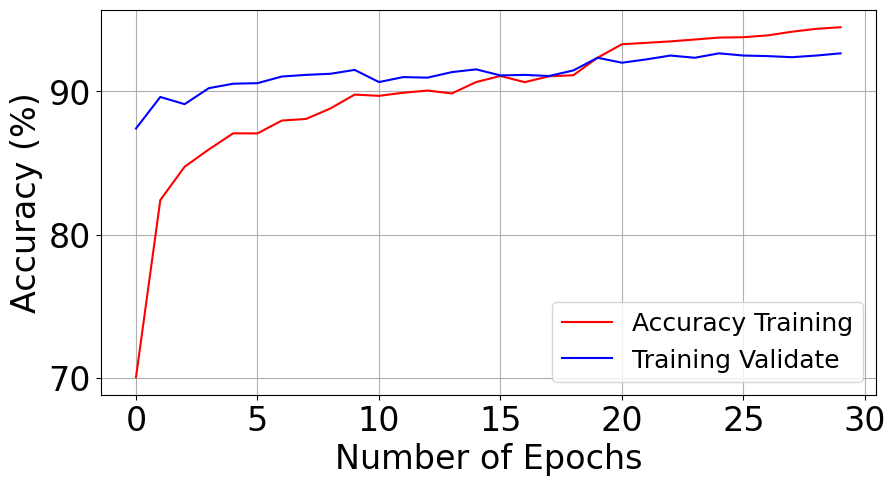

In [10]:
num_epochs_done = len(hist.history['loss'])

plotTraining(hist, num_epochs_done, "loss")
plotTraining(hist, num_epochs_done, "accuracy")
plotTraining(hist, num_epochs_done, "val_loss")
plotTraining(hist, num_epochs_done, "val_accuracy")

Found 1881 images belonging to 23 classes.
              precision    recall  f1-score   support

           0     0.9457    0.9760    0.9606       125
           1     0.9914    0.9583    0.9746       120
           2     0.9397    0.9083    0.9237       120
           3     0.9000    0.8571    0.8780       105
           4     0.9375    1.0000    0.9677        60
           5     0.9318    0.9880    0.9591        83
           6     0.9206    0.9667    0.9431        60
           7     0.9459    0.9091    0.9272        77
           8     0.9804    1.0000    0.9901        50
           9     0.9722    1.0000    0.9859        70
          10     0.9873    0.9750    0.9811        80
          11     0.9462    0.9263    0.9362        95
          12     0.9710    0.9853    0.9781        68
          13     0.9254    0.9688    0.9466        64
          14     0.9833    0.9077    0.9440        65
          15     0.8133    0.8714    0.8414        70
          16     0.9242    0.9531    0

<Figure size 1500x1500 with 0 Axes>

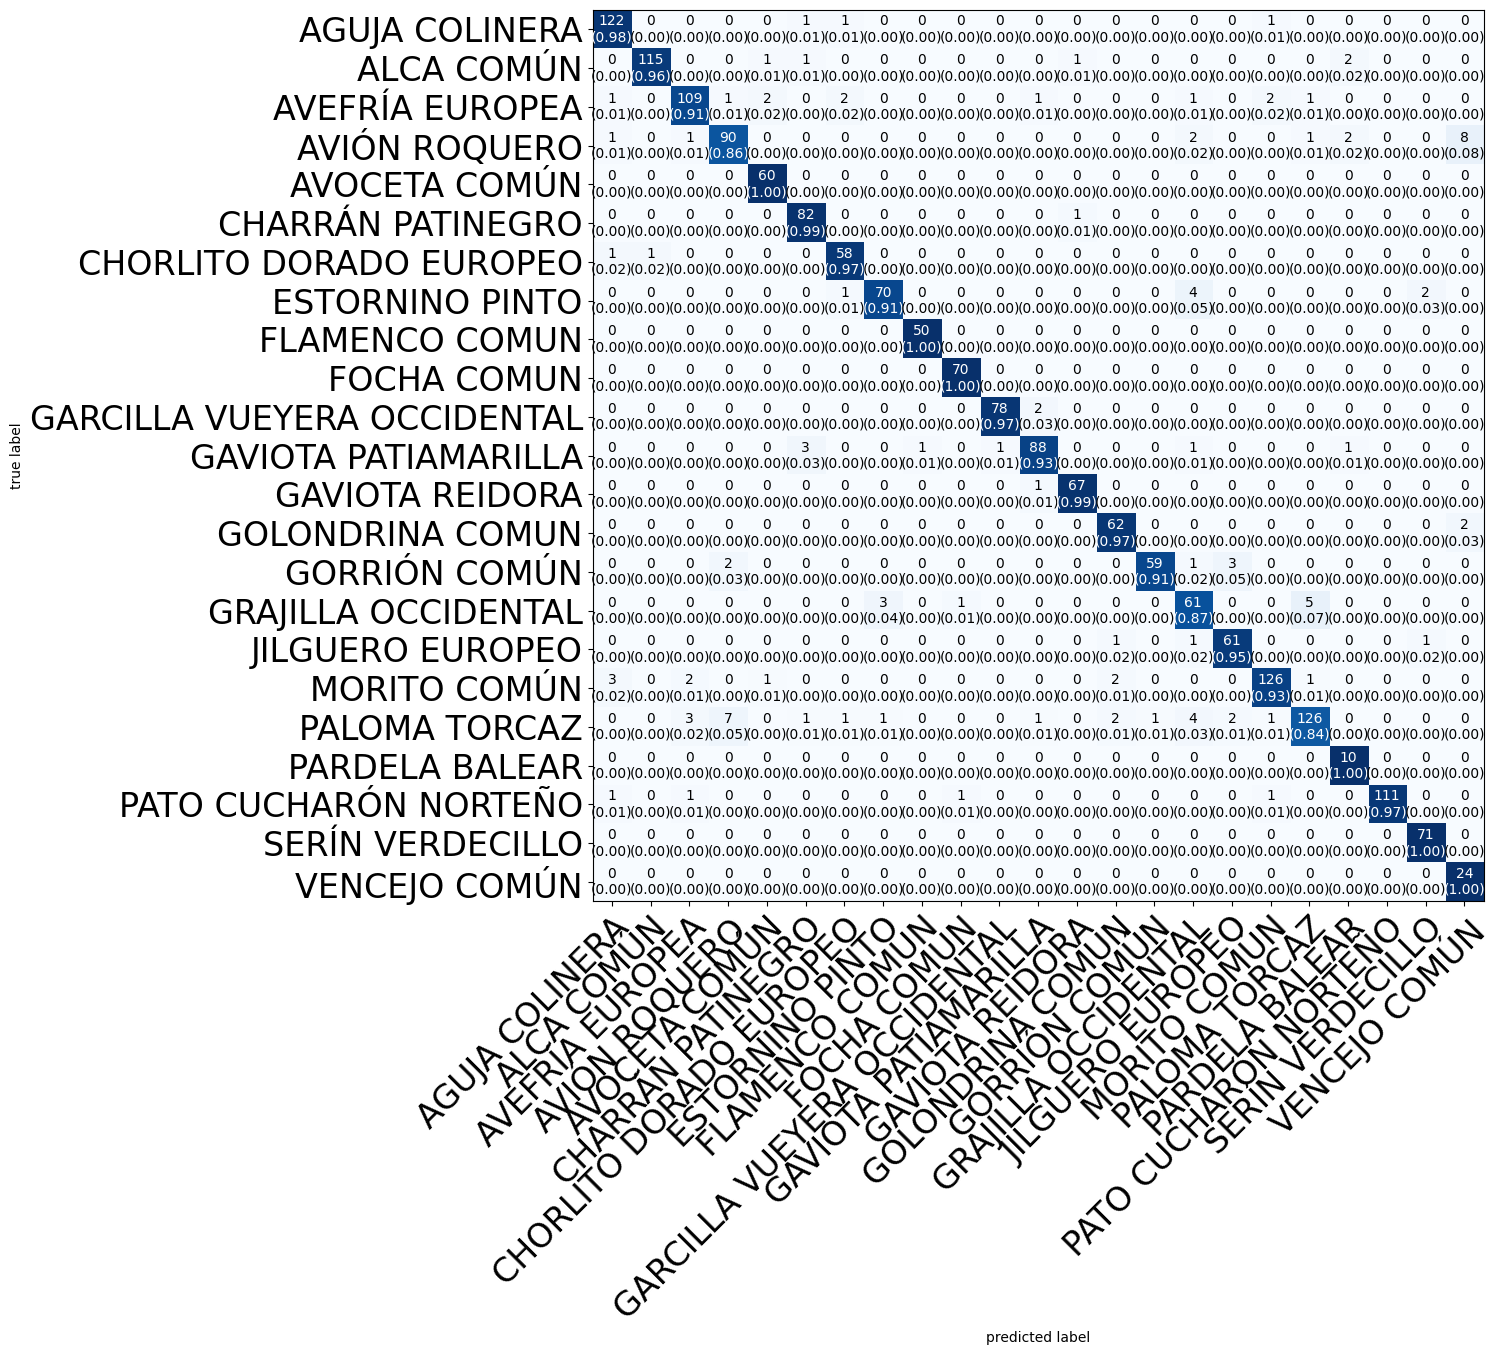

In [15]:
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
%matplotlib inline

# nombres de las clases
names = ['AGUJA COLINERA',
          'ALCA COMÚN',
          'AVEFRÍA EUROPEA',
          'AVIÓN ROQUERO',
          'AVOCETA COMÚN',
          'CHARRÁN PATINEGRO',
          'CHORLITO DORADO EUROPEO',
          'ESTORNINO PINTO',
          'FLAMENCO COMUN',
          'FOCHA COMUN',
          'GARCILLA VUEYERA OCCIDENTAL',
          'GAVIOTA PATIAMARILLA',
          'GAVIOTA REIDORA',
          'GOLONDRINA COMUN',
          'GORRIÓN COMÚN',
          'GRAJILLA OCCIDENTAL',
          'JILGUERO EUROPEO',
          'MORITO COMÚN',
          'PALOMA TORCAZ',
          'PARDELA BALEAR',
          'PATO CUCHARÓN NORTEÑO',
          'SERÍN VERDECILLO',
          'VENCEJO COMÚN']

# Definir el generador de datos de prueba
test_data_dir = r'C:\Users\johns\Desktop\TFG\Dataset\test'

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(height_shape, width_shape),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

# Load the model
#custom_Model= load_model(r"C:\Users\johns\Desktop\TFG\MasCapas\EfficientNet\custom_EfficientNet_model.h5")

# Make predictions
predictions = custom_efficientnet_model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(y_real, y_pred)
plt.figure(figsize=(15, 15))
plot_confusion_matrix(conf_mat=conf_matrix, figsize=(15, 15), class_names=names, show_normed=True)
plt.tight_layout()

# Print classification report
print(classification_report(y_real, y_pred, digits=4))

In [16]:
print(y_real)

[ 0  0  0 ... 22 22 22]


In [17]:
print(y_pred)

[ 0  0  0 ... 22 22 22]
